# Language detection of transliterated text

### The problem
Below is a text transliterated in English:

| "aaj ka mausam achchha hai" | "The weather is good today" |
| --- | --- |
| (transliterated text) | (translated text) |

One might be curious about what language is this transliterated text actually in (unless one knows that language already). Happens to me quite often, when I'm reading Youtube or Facebook or other social media threads.

Well, the above text is in Hindi:

| "aaj ka mausam achchha hai" | "आज का मौसम अच्छा है" |
| --- | --- |
| (transliterated text) | (original script) |

Since computer and phone keyboards are generally in English, it is often convenient for non-roman language speakers to transliterate their texts to English while typing than to use the original script (writing system) of their language. Since the transliterated text does not have the information about its original language, it becomes hard for others (who do not speak that language) to even decipher the language and further understand the meaning of the text.

It would be convenient if machines could fill this gap by telling us the language of those transliterated texts, which we very often encounter in social media threads etc., so that we don't have to ask other people if they can identify the language of a transliterated text.

### Scope of the project

In this project, I therefore attempt to address this problem by designing an NLP model which can detect the language of a transliterated text. Due to lack of time at the moment, I confine the scope of this project to just classify texts transliterated from Korean and Bangla (Bengali) languages. 

Although not important, but the reason for choosing these two non-roman languages in particular for the project is because:  
* Bangla is my mother tongue so it would be fun to teach the machine my language. Bangla (or Bengali) is spoken mostly in the state of West Bengal in India and in Bangladesh. 
* Korean pop songs are popular lately, so considering their international reach, I thought, Korean transliteration might be relevant to people.
* I shall be including other non-roman languages in the future.

### Solution approach

We can often identify a language being spoken, if we have prior experience of hearing that language, even if we may not understand the language at all. Every language has some characteristic sounds patterns. These patterns can be used to identify a language even without understanding them. So, like speech, if we know the correct pronounciation of transliterated texts (ie pronounciation in their original langauge), we might be able to identify the language, given we have some prior familiarity with how the language generally sounds.

Automatic Speech Recognition (ASR) systems are pretty decent in identifying language from speech audio inputs. ASRs use spectrograms (shown below) to learn features of a speech input such as its language.

<img src="https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png"  width="400">

[Image source: Kovitvongsa, Kathryn & Lobel, Phillip. (2019). Convenient Fish Acoustic Data Collection in the Digital Age.]

In spectrograms, audio files are chopped into thin time slices (in the abscissa), and for each time slice, all the frequencies present in it are plotted (in the ordinate) with their corresponding intensities are represented in the heat map, obtained using Fourier transform. The frequencies tell us about the nature of the source that produced that sound, e.g., you can identify musical instruments by the pattern of their overtones (multiples of fundamental frequency).

So, in spectrograms of human speech audio files, the frequencies in a particular time slice should indicate the part of buccal cavity that produced it. It would be ideal if one knew the time span of each characteristic sound that create the words in a language. However, since that is not known, in spectrograms, the time is sliced into very small intervals, so that the NLP model can join a few of those small time slices and learn the actual length of a particular characteristic sound.

If we could split our transliterated words into fragments which represent the characteristic sounds, a string of those word fragments would be analogous to spectrograms for audio speech. We can then use those word fragment strings as inputs to an NLP model to identify the language of the transliterated text.

Fortunately, when a text is transliterated from one langauge to other, it is generally spelled out phonetically (even if the original language is not strictly phonetic). So, if we were to phonetically pronounce the transliterated words, we might be quite closer to its actual pronounciation.

To get the phonetic pronounciation, we assumed that the texts were transliterated from some unknown language to Italian, a strictly phonetic language which also uses the Latin script as English. We then divide the transliterated words into syllables according to the  Italian language, ie phonetically. We used those (phonetic) syllables as inputs to our NLP model.

# Data scraping

Song lyrics website often transliterate songs in English (perhaps for international audiences). So, for Korean and Bangla (Bengali) sentences transliterated in English, the song lyrics on the following lyrics websites were scraped:
 - bangla lyrics: http://www.lyricsbangla.com/
 - korean lyrics: https://romanization.wordpress.com/

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

Since the objects in Bengali (referred as Bangla henceforth) and Korean texts might be different created two separate functions to fetch respective text. The different functions are just for cleanliness purpose.

### Functions for scraping Korean transliterated texts

In [3]:
def fetch_korean(fname):
    #some browsing revealed there are 1087 pages (@29th July, 2019) indexed 0 through 1086 with links to lyrics
    #extracting the song links from each of these pages
    npages = 1087
    lyricsbag = open(fname, 'w')
    count = 0
    for pg in range(npages):
        soup = BeautifulSoup(urlopen("https://romanization.wordpress.com/page/%i"%pg), 'html.parser')
        links = soup.find_all('a')
        pageurls = [_.get('href') for _ in links if (_.text == 'Continue reading →')]
        for url in pageurls:
            b = koreanLyrics(url)
            [lyricsbag.write(_+"\n") for _ in b]
            count += 1
            print(count)
    
    return


In [4]:
def koreanLyrics(url):
    s = BeautifulSoup(urlopen(url), 'html.parser')
    lblob = [_.text for _ in s.find_all('p')]
    lyrics = []
    pendown = False
    for _ in lblob:
        if pendown:
            if (_ == "//"):
                pendown = False
                break
            else:
                lyrics += _.split("\n")
        else:
            if "to see the lyrics" in _:
                pendown = True
    return lyrics

### Functions for scraping Bangla transliterated texts

In [5]:
def fetch_bangla(fname):
    #url = "http://www.lyricsbangla.com/?sec=listing&lyricid=4140"
    url = "file:///home/sourav/MLProjects/transliterate/Lyrics%20Search%20»%20LyricsBangla.com.html" 
    #TODO replace the static page with dynamic link smh
    #"http://www.lyricsbangla.com/index.php?sec=search"
    html = urlopen(url)

    soup = BeautifulSoup(html, 'html.parser')
    b = soup.find('table')
    urltable = b.find_all('td')
    
    #extracting songs from links in www.lyricsbangla.com index page
    lyricsurllist = []
    lyricsbag = open(fname, 'w')
    count = 0
    for u in urltable:
        if (u.find('a') != None):
            songlink = u.a.get('href')
            if ("artist" not in songlink):
                b = banglaLyrics(songlink)
                [lyricsbag.write(_+"\n") for _ in b]
                count += 1
                print(count)
        
    return
    

Bangla lyrics often have chords, so here is a list of chords to clean the text scraped from: https://www.pianochord.org/ and saved in "chords.txt"

In [6]:
##(source: https://www.pianochord.org/)
def get_musicalchords():
    chords_ = []
    f = open("chords.txt", 'r')
    lines = f.readlines()
    for l in lines:
        chords_ += l.strip().split()

    return chords_

In [7]:
def banglaLyrics(url):
    spchar = re.compile('[@_!#$%^&*()<>?/\|}{~:]')


    s = BeautifulSoup(urlopen(url), 'html.parser')
    lblob = s.find('p', id='tabs-1')
    lyrics = []
    chord_ = get_musicalchords()
    for line in lblob:
        if (line.string != None):
            l = str(line)
            if any(chord in l for chord in chords_):
                continue
            elif (spchar.search(l)!=None):
                continue
            else:
                l = l.strip()
                if (l): lyrics.append(l)
    return lyrics

The following cell scrapes Bangla and Korean lyrics respectively using the functions defined above.

In [145]:
banglacorpus = "banglacorpus.txt"
fetch_bangla(banglacorpus)


koreancorpus = "koreancorpus.txt"
fetch_korean(koreancorpus)


# Data Cleaning

"cleanedkoreancorpus.txt" and "cleanedbanglacorpus.txt" are the cleaned corpuses for Korean and Bangla transliterated text used for the analysis

<div style="text-align: right"> "Cleaning is messy!!" ~Anonymous </div>

# Data Visualization for encoding

In [166]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pyphen

While transliteration, words are spelled phonetically. So, if one spells the transliterated word phonetically, one might actually get quite close to the actual pronounciation in its native language.
If the transliterated words are, therefore, split into phonetic syllables, a list of those phonetic syllables could represent the pronounciation of that word and thus information about its native language. These phonetic syllables are quite analogous to phoneme sequences used in ASR (Automatic Speech Recognition).

Since English is not a phonetic language, its syllables are not phonetic. However, with we try to split the word using a phonetic language, like Italian, then the syllables would indeed be phonetic.

I use a python package - 'pyphen' (https://pyphen.org) for such syllable splitting. This package provides an option to choose the language in which the user wants to split the word. As discussed above, I used Italian, a phonetic language, to split the word into syllables, so that I get phonetic syllables.

The function below splits the words phonetically (as in italian) into list of syllables using Pyphen:

In [169]:
def PhoneticWordSplit(word):
    dic = pyphen.Pyphen(lang='it_IT')
    splitword = dic.inserted(word)
    splitword = splitword.replace("-", " ")
    return splitword

The words split into phonetic syllables are stored in koreanwordbag.txt and banglawordbag.txt for Korean and Bangla resp. and used to train and test the langauge detection model.

In [170]:
def WordBagMaker(corpusfilename, label):
    f = open(corpusfilename, 'r')
    lines = f.readlines()

    import random
    worddict = []
    for l in lines:
        words = l.split()
        #only words present in sentences used, not single word sentences
        if (len(words) < 2): continue 
        for w in words:
            #words with digits not used and single letter words not used
            if (len(w) > 1) and w.isalpha(): 
                worddict.append(PhoneticWordSplit(w) + " : " + label)
    #shuffle the list
    random.shuffle(worddict)   
    return worddict

for lang in ['korean', 'bangla']:
    fl = open("%swordbag.txt"%lang, 'w')
    [fl.write(_+"\n") for _ in WordBagMaker("cleaned%scorpus.txt"%lang, "K" if lang=='korean' else "B" )]
    fl.close()

In [100]:
datakor = open("koreanwordbag.txt", 'r').readlines()
databan = open("banglawordbag.txt", 'r').readlines()

A quick feature visualization to see if simple features, like syllable count per word,have any discriminating power.

In [102]:
def getfeatures(langcorpus):
    syllables_per_word = []
    letters_per_syllable = []
    for d in langcorpus:
        splitword = d.split(" : ")[0].split(" ")
        syllables_per_word.append(len(splitword))
        [letters_per_syllable.append(len(_)) for _ in splitword]
    return syllables_per_word, letters_per_syllable

syllables_per_wordKOR, letters_per_syllableKOR = getfeatures(datakor)

syllables_per_wordBAN, letters_per_syllableBAN = getfeatures(databan)

syllables_per_word = np.concatenate((syllables_per_wordKOR,syllables_per_wordBAN), axis=0)
letters_per_syllable = np.concatenate((letters_per_syllableKOR, letters_per_syllableBAN), axis=0)

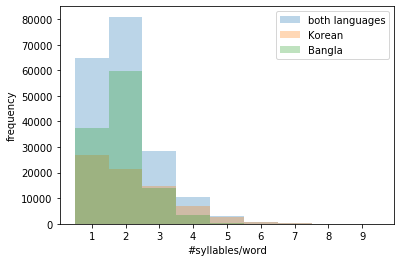

In [103]:
binsSPW = [_ - 0.5 for _ in range(1,11)]
plt.xticks(range(1,11))
plt.hist(syllables_per_word, binsSPW, alpha=0.3, label='both languages')
plt.hist(syllables_per_wordKOR, binsSPW, alpha=0.3, label='Korean') 
plt.hist(syllables_per_wordBAN, binsSPW, alpha=0.3, label='Bangla')

plt.xlabel('#syllables/word')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

Bangla words mostly have 2 syllables, Korean words can have upto 5 syllables in a word. A 10 syllable vector should be enough to encode a word from either language.

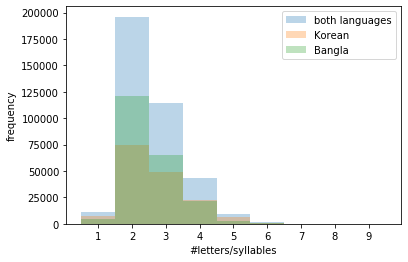

In [104]:
binsLPS = [_ - 0.5 for _ in range(1,11)]
plt.xticks(range(1,11))
plt.hist(letters_per_syllable, binsLPS, alpha=0.3, label='both languages')
plt.hist(letters_per_syllableKOR, binsLPS, alpha=0.3, label='Korean') 
plt.hist(letters_per_syllableBAN, binsLPS, alpha=0.3, label='Bangla')

plt.xlabel('#letters/syllables')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

Most phonetic syllables have around 2 letters. Not a significant disciminator. Would therefore be fair to disregard the syllable length and just integer encode the syllables in both the corpuses.

# Training data

Using 50,000 (10,000) Bangla and Korean words each randomly from the corpuses for training (testing).

In [107]:
Ntrain = 50000
Ntest  = 10000
random.shuffle(datakor) #korean
random.shuffle(databan) #bangla
TrainingVal_data = datakor[:Ntrain] + databan[:Ntrain] 
Testing_data = datakor[Ntrain:Ntrain+Ntest] + databan[Ntrain:Ntrain+Ntest]
random.shuffle(TrainingVal_data)
random.shuffle(Testing_data)

# Word and label encoding

In [79]:
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.sequence import pad_sequences

In [43]:
vocab_size = 30
v = ['in in in', 'kab bo', 'so kal']
encoded_docs = [hashing_trick(d, vocab_size, hash_function='md5') for d in v]
encoded_docs
v1 = ['in in bo']
encoded_docs1 = [hashing_trick(d, vocab_size, hash_function='md5') for d in v1]
print(encoded_docs1)
print(encoded_docs)

[[26, 26, 3]]
[[26, 26, 26], [15, 3], [26, 15]]


In [80]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2

In [155]:
def datalabel(dataset):
    '''function to label words 'K' or 'B' for Korean and Bangla resp. '''
    wvec = []
    lvec = [] 
    for td in dataset:
        tw, tl = td.split(" : ")
        #One hot encoding: [1,0] : Bangla, [0,1] : Korean
        l = [1, 0] if tl.strip() == "B" else [0,1] 
        wvec.append(tw)
        lvec.append(l)
    return wvec, np.array(lvec)

Pipeline to integer encode phonetic syllables and pad words to a max of 10 syllables:

In [159]:
def IntEncodeWords(wordlist):
    vocab_size = 200000
    max_length = 10
    #integer encoding the syllables
    encoded_words = [hashing_trick(d, vocab_size, hash_function='md5') for d in wordlist]
    #padding to a max length of 10
    padded_words = pad_sequences(encoded_words, maxlen=max_length, padding='post')
    return padded_words

Processing the training and testing data with the above pipeline

In [158]:
#training data
wordvec, labelvec = datalabel(TrainingVal_data)
print(wordvec[:3])
print(labelvec[:3])
padded_docs = IntEncodeWords(wordvec)

#testing data
wordvec_test, labelvec_test = datalabel(Testing_data)
padded_docs_test = IntEncodeWords(wordvec_test)
print(wordvec_test[:5])
print(encoded_docs_test[:5])

['nal', 'mi chyeo ga na b wa', 'ai']
[[0 1]
 [0 1]
 [0 1]]
['jeil', 'sa ran ghaeoh', 'sa ran ghae', 'aka sh', 'dal la jyeos seo']
[[55208], [67026, 161580, 152147], [67026, 161580, 25207], [48363, 63007], [9265, 18646, 109198, 141814]]


I train an LSTM to classify Korean and Bangla words, defined below:

In [111]:
lstm_out = 5
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(LSTM(lstm_out, recurrent_initializer="random_uniform", bias_initializer="zeros", dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 8)             1600000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 280       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 12        
Total params: 1,600,292
Trainable params: 1,600,292
Non-trainable params: 0
_________________________________________________________________
None


Early stopping the training if validation loss starts to converge (wait for 50 epochs to make sure validation loss is indeed converging). 

In [112]:
from keras.callbacks import EarlyStopping
class ThresholdEarlyStopping(EarlyStopping):
    def __init__(self, monitor='val_loss', min_epochs=10,
                 threshold=0.995, increase=1.75, verbose=0, mode='auto'):

        super(ThresholdEarlyStopping, self).__init__(
            monitor=monitor,
            patience=min_epochs,
            verbose=verbose,
            mode=mode
        )

        self.threshold = threshold
        self.increase = increase

    def on_epoch_end(self, epoch, logs={}):
        if epoch < self.patience:
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Early stopping requires %s to be available!'
                              % (self.monitor), RuntimeWarning)

            if self.monitor_op(current, self.best):
                # if current val_loss within 0.5% margin of the best(min) val_loss, 
                # add some grace to the patience to monitor if val_loss is indeed converging 
                if self.monitor_op(current, self.threshold*self.best):
                    self.patience = max(self.patience, epoch*self.increase)
                self.best = current

        else:
            if self.verbose > 0:
                print('Epoch %05d: early stopping' % (epoch))

            self.model.stop_training = True

In [113]:
# fit the model
print(labelvec[:5])
history = model.fit(padded_docs, labelvec, batch_size=2000, validation_split=0.1, epochs=500, verbose=1, callbacks=[ThresholdEarlyStopping(verbose=1, min_epochs=50)])

[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]
Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 3s 36us/step - loss: 0.8363 - acc: 0.5272 - val_loss: 0.8187 - val_acc: 0.5392
Epoch 2/500
90000/90000 [==============================] - 2s 20us/step - loss: 0.8040 - acc: 0.6119 - val_loss: 0.7891 - val_acc: 0.8677
Epoch 3/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.7690 - acc: 0.7265 - val_loss: 0.7366 - val_acc: 0.7410
Epoch 4/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.6231 - acc: 0.8391 - val_loss: 0.4600 - val_acc: 0.9033
Epoch 5/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.4186 - acc: 0.9046 - val_loss: 0.3429 - val_acc: 0.9264
Epoch 6/500
90000/90000 [==============================] - 3s 30us/step - loss: 0.3586 - acc: 0.9267 - val_loss: 0.3144 - val_acc: 0.9287
Epoch 7/500
90000/90000 [==============================] - 2s 26us/step - loss: 0.3318

check for overfitting by comparing the validation loss with training loss:

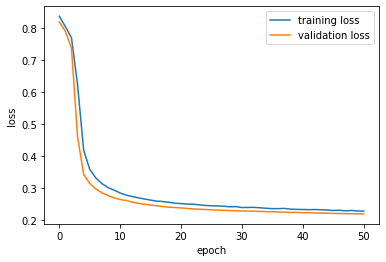

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='best')
plt.show()

The model is trained.

evaluating the LSTM language classifier with testing data (with default decision boundary = 0.5):

In [142]:
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, labelvec_test, verbose=0)
print('Accuracy: %.2f %%' % (accuracy*100))

Accuracy: 93.36 %


Optimizing the decision boundary of the LSTM classifier for best accuracy using ROC curve:

In [134]:
from sklearn.metrics import roc_curve, auc
labelvec_pred = model.predict(padded_docs_test)
fpr, tpr, cut = roc_curve(labelvec_test.ravel(), labelvec_pred.ravel())
AUC = auc(fpr, tpr)

In [135]:
labelvec_pred[:5], labelvec_test[:5, 0]

(array([[0.00991759, 0.99008244],
        [0.1209347 , 0.8790653 ],
        [0.00542074, 0.9945793 ],
        [0.995492  , 0.00450803],
        [0.00368168, 0.99631834]], dtype=float32), array([0, 0, 0, 1, 0]))

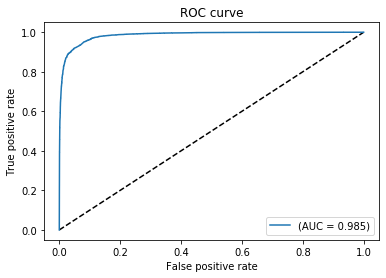

In [136]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(AUC = {:.3f})'.format(AUC))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Closest point to (0,1) on the ROC above will have the optimal threshold (which reduces error conributed from both type I and II errors):

In [137]:
tprDist = np.square(tpr-1)
fprDist = np.square(fpr)
DistFromPerfectEff = tprDist + fprDist

Optimum_cut = cut[DistFromPerfectEff.argmin()]
Optimum_cut

0.4986838

Optimal threshold at 0.5 (default cut for accuracy).

## Storing the model

In [138]:
from keras.models import model_from_json

#model to json
model_json = model.to_json()
json_file = open("translit.json", "w")
json_file.write(model_json)
#weights to h5
model.save_weights("translit.h5")
print("model saved to disk")

model saved to disk


## Loading the model

In [139]:
# load model
jfile = open('translit.json', 'r')
loaded_model_json = jfile.read()
jfile.close()
loaded_model = model_from_json(loaded_model_json)
# load weights
loaded_model.load_weights("translit.h5")
print("Loaded model from disk")
# compile the loaded model
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Loaded model from disk


The loaded model reproduces the accuracy for transliterated words:

In [143]:
# evaluate the loaded model
loaded_loss, loaded_accuracy = loaded_model.evaluate(padded_docs_test, labelvec_test, verbose=0)
print('Accuracy: %.2f %%' % (loaded_accuracy*100))

Accuracy: 93.36 %


Using Maximum Likelihood Estimator to predict the language of an entire transliterated sentence, from the individual scores of the words in that sentence:

$$Prediced\ Language = \underset{l}{\operatorname{argmax}} \sum_{i=1}^{all\ words\ in\ sentence} log(P(word_{i}|l))$$

   
   where $l \in \{ Korean, Bengali \} $
   
   and $P(word|l)$ is output score of the word from the LSTM classifier for language $l$
   

In [187]:
import string

def TextToInput(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).split()
    text = [PhoneticWordSplit(w) for w in text]
    return IntEncodeWords(text)

In [200]:
def PredictLanguage(text):
    lstminput = TextToInput(text)
    p = model.predict(lstminput)
    langdict = {0:"Bengali", 1:"Korean"}
    mle = np.log(p)
    mle = np.sum(mle, axis=0)
    return langdict[np.argmax(mle)]

In [214]:
inputtext = "cheoeumbuteo geudaeyeossjyo \
naege dagaol han saram \
dan han beonui seuchimedo \
nae nunbicci mareul hajyo"

#"Amake naam~ #ki?!@"
PredictLanguage(inputtext)

'Korean'

## Results
   
   The LSTM classifier using phonetic syllables as input features is able to give an optimum accuracy of ~93 % with AUC = 0.985.

### Next steps:

 * Create a web-app to run the NLP model and host on google cloud.

 * Perform k-fold cross-validation to better estimate classifier's performance
 * Should test vanilla RNN too since the input string of phonetic syllables are not too long
 * Improve cleaning to get rid of non-lexical vocables in the corpus to train a better discriminator
 * Try to find other sources (than song lyrics) for Korean and Bangla transliterated texts
 * Think of a better way to reduce even further English words that are contaminating the corpuses
 * Add other non-roman langauges